<a href="https://colab.research.google.com/github/ShovalBenjer/deep_learning_neural_networks/blob/main/Deep_exc_2_adir_shoval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TL;DR:**

**Collaborators: Shoval Benjer 319037404, Adir Amar 209017755**

This assignment focuses on Implementing a neural network in PyTorch to solve the XOR problem.
Exploring configurations of the network by specific instructions.
Documenting results with reproducible experiments and clear outputs.

**For Our Personal Opinion**, this assignment is a great start for creating a neural network train, have issues like vanishing/exploding gradients and avoiding local minimas with maybe one of the smallest samples possible. I had great time enjoying building,debugging and exploring possibilites and possible outcomes during this time, hopefully for a better usage of modern optimizers tools like Adam and etc.

### **Comparison Table**

| **Experiment** | **Learning Rate (lr)** | **Hidden Units** | **Bypass** | **Mean Epochs** | **Std Epochs** | **Mean Train Loss** | **Mean Val Loss** | **Fail Count** | **Observation** |
|-----------------|-------------------------|------------------|------------|------------------|----------------|---------------------|-------------------|----------------|-----------------|
| **1**          | 0.25                   | 1                | True       | 4861.8           | 699.3          | 0.0301              | 0.0453            | 0              | Best performance: fastest convergence, lowest loss, no failures. |
| **2**          | 0.1                    | 4                | False      | 7417.2           | 1289.8         | 0.0258              | 0.0376            | 0              | Moderate performance: good convergence and low loss. |
| **3**          | 0.1                    | 2                | True       | 7692.2           | 1325.4         | 0.0347              | 0.0497            | 0              | Slightly slower than Experiment 2 due to bypass. |
| **4**          | 0.1                    | 4                | True       | 7861.1           | 1335.8         | 0.0315              | 0.0503            | 0              | Increased hidden units slow convergence further. |
| **5**          | 0.1                    | 2                | False      | 7029.3           | 1459.1         | 0.0288              | 0.0369            | 1              | Good performance but with one failure. |
| **6**          | 0.01                   | 2                | False      | 30300.8          | 5188.1         | 0.1077              | 0.1258            | 10             | Poor convergence due to low learning rate. |
| **7**          | 0.01                   | 2                | True       | 32571.8          | 3321.6         | 0.1363              | 0.1689            | 6              | Bypass further increases complexity at low learning rate. |
| **8**          | 0.01                   | 4                | False      | 35293.8          | 2819.4         | 0.0978              | 0.1287            | 10             | High hidden units worsen poor performance from low learning rate. |
| **9**          | 0.01                   | 4                | True       | 33227.0          | 3080.5         | 0.1216              | 0.1580            | 8              | High hidden units and bypass amplify poor convergence. |

---

### **Final Note**
- **Best Configuration:** Experiment 1 (`lr=0.25`, `hidden=1`, `bypass=True`) achieves the fastest convergence, lowest losses, and no failures. Simpler models with high learning rates are well-suited for the XOR problem.
- **Poor Performers:** Experiments 6-9 suffer from **low learning rate (`lr=0.01`)**, causing slow convergence and high fail counts, exacerbated by **increased complexity** (higher hidden units or bypass).
- **Key Takeaway:** For small-scale tasks like XOR, simplicity and efficient optimization (e.g., higher learning rate, fewer hidden units) outperform more complex architectures.

**Graphs Plotted during this Notebook:**

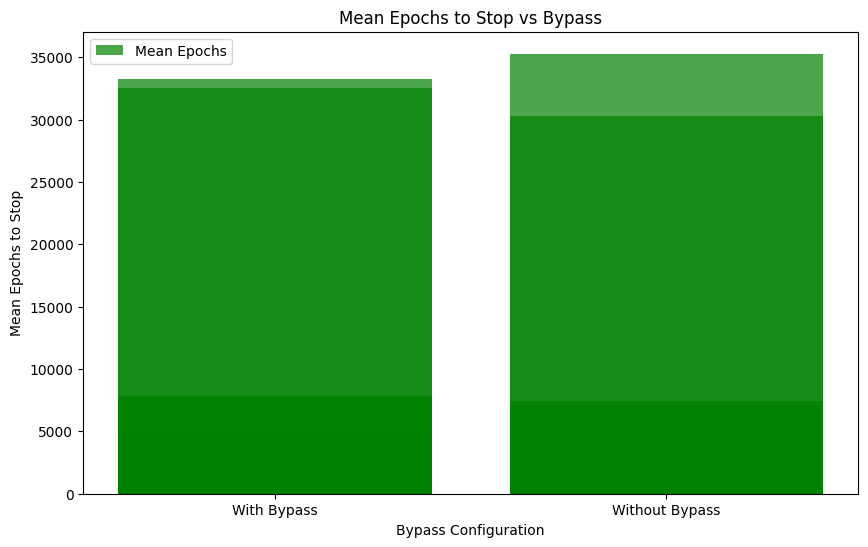

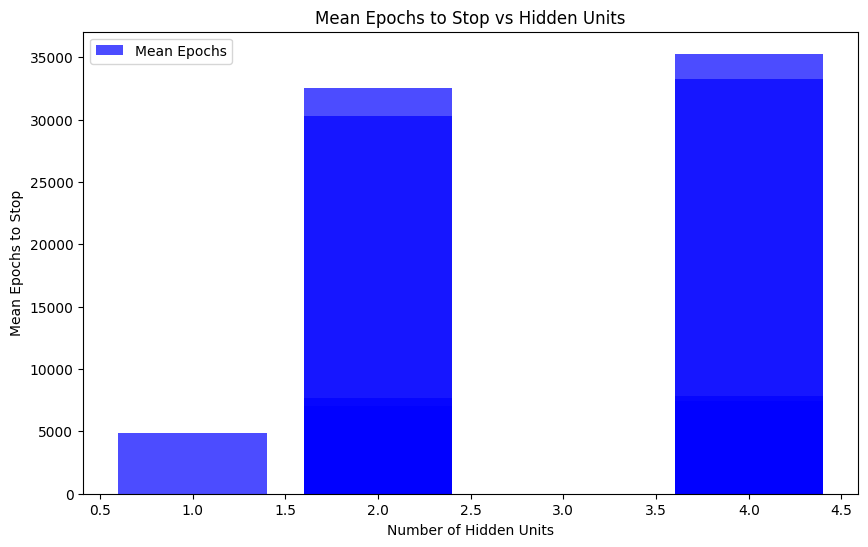

# **Setup and Imports:**


To run this code, you'll need the following requirements:

Python 3.x

PyTorch

NumPy

Pandas

You can install these requirements using pip:

`!pip install torch numpy pandas`

To run the code:

1. Copy the provided code into a Python file (e.g., xor_network.py)
2. Run the file using Python:
`python xor_network.py`

If you need to run this in VLab:
Log in to your VLab account
Open a terminal
**Ensure the required packages are installed** (use the pip command above if needed)
Navigate to the directory containing your Python file
Run the file using Python as described above
The code will automatically run experiments for k=1 (with bypass), k=2, and k=4, displaying the weights, biases, loss values, and truth tables for each configuration.

Note: The code uses a low temperature (0.001) for the BTU/sigmoid function as requested in the assignment. No additional setup is required beyond having the necessary Python packages installed.

os: Used for operating system-dependent functionality, such as managing file paths and environment variables.

torch, torch.nn, torch.optim: Core PyTorch libraries for building, training, and optimizing neural networks.

numpy: Provides efficient numerical operations for handling arrays and
mathematical computations.

statistics: Enables statistical calculations like mean and standard deviation for analyzing experiment results.

multiprocessing (Manager, Pool): Facilitates parallel execution of experiments to reduce computational time.

tqdm: Creates progress bars to visualize the progress of experiment runs for better user feedback.

In [ ]:
!pip install torch matplotlib

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import statistics
from multiprocessing import Manager, Pool
from tqdm import tqdm

# **Configuration and Data Definition**
Here we define the training and validation sets. According to the assignment,

we train a small MLP to learn the XOR function, with a validation set that includes some additional points.

**Training set:** the standard XOR pattern

**Validation set:** includes the training points plus additional specified points.

**Stopping criteria:**

1) Stop successfully if the validation loss hasn't improved by more than 0.0001 over the last 10 epoch AND val_loss < 0.2.

2) Stop with failure if we reach more than 40,000 epochs with no success condition met.

**Experiments:**
We have 8 experiments with combinations of:

LR ∈ {0.1, 0.01}, hidden ∈ {2,4}, bypass ∈ {False,True}

This yields 2x2x2=8 experiments.

Plus a 9th custom experiment: LR=0.25, hidden=1, bypass=True.


In [3]:
# Define constants
MAX_EPOCHS = 40000
PATIENCE = 10
IMPROVEMENT_THRESHOLD = 0.0001
VAL_LOSS_GOAL = 0.2

# Define datasets
train_x = torch.tensor([[0., 0.],
                        [0., 1.],
                        [1., 0.],
                        [1., 1.]], dtype=torch.float32)
train_y = torch.tensor([[0.],
                        [1.],
                        [1.],
                        [0.]], dtype=torch.float32)
val_x = torch.tensor([[0., 0.],
                      [0., 1.],
                      [1., 0.],
                      [1., 1.],
                      [1., 0.1],
                      [1., 0.9],
                      [0.9, 0.9],
                      [0.1, 0.9]], dtype=torch.float32)
val_y = torch.tensor([[0.],
                      [1.],
                      [1.],
                      [0.],
                      [1.],
                      [0.],
                      [0.],
                      [1.]], dtype=torch.float32)

experiment_params = [
    (0.1, 2, False),
    (0.1, 2, True),
    (0.1, 4, False),
    (0.1, 4, True),
    (0.01, 2, False),
    (0.01, 2, True),
    (0.01, 4, False),
    (0.01, 4, True),
    (0.25, 1, True)
]

# **Model Definition**

Network Class

Defines a simple MLP with one hidden layer.

**__init__**: Sets up the architecture with configurable hidden neurons and an optional bypass connection.

initialize_weights: Uses Xavier initialization to ensure proper weight scaling, avoiding vanishing/exploding gradients.

forward: Implements the forward pass, applying a sigmoid activation and optionally concatenating the input for bypass functionality.

**train_model**

Handles training the network with gradient descent (SGD) and binary cross-entropy loss (BCELoss).

Training: Performs backpropagation using .backward() and updates weights via .step().

Validation: Monitors validation loss to evaluate generalization and enforce early stopping.

Logging: Outputs progress every UPDATE_EPOCH_STEP to track training.

Early Stopping Criteria:

Condition 1: Stops if validation loss doesn't improve by more than IMPROVEMENT_THRESHOLD for PATIENCE epochs and VAL_LOSS_GOAL is achieved.

Condition 2: Halts after MAX_EPOCHS if the model fails to meet Condition 1.
Why These Methods?

Xavier Initialization: Ensures stable gradients during training, improving convergence.

BCELoss and Sigmoid Activation: Align with the binary classification nature of the XOR task.

Gradient Descent (SGD): A simple, assignment-compliant optimizer for parameter updates.

Early Stopping: Prevents unnecessary training and reduces overfitting.

Bypass Option: Enables experimentation with input concatenation to improve learning capacity.

In [4]:
class Network(nn.Module):
    """
    A simple Multi-Layer Perceptron (MLP) for XOR-like tasks.

    Parameters
    ----------
    hidden_size : int
        The number of hidden neurons.
    bypass : bool, optional
        Whether to concatenate the input directly to the output layer's input. Default is False.
    """

    def __init__(self, hidden_size, bypass=False):
        super(Network, self).__init__()
        self.bypass = bypass
        self.hidden = nn.Linear(2, hidden_size)
        out_input_size = hidden_size + (2 if bypass else 0)
        self.output = nn.Linear(out_input_size, 1)
        self.activation = nn.Sigmoid()
        self.initialize_weights()

    def initialize_weights(self):
        """
        Initializes weights of the network using Xavier initialization.

        Ensures weights are scaled based on the number of input and output neurons for symmetry.
        """
        nn.init.xavier_uniform_(self.hidden.weight)
        nn.init.zeros_(self.hidden.bias)
        nn.init.xavier_uniform_(self.output.weight)
        nn.init.zeros_(self.output.bias)

    def forward(self, x):
        """
        Forward pass of the network.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor of shape (N, 2).

        Returns
        -------
        torch.Tensor
            The scalar output after the forward pass, shape (N, 1).
        """
        h = self.activation(self.hidden(x))
        if self.bypass:
            h = torch.cat((x, h), dim=1)
        return self.activation(self.output(h))

# Define constants
UPDATE_EPOCH_STEP = 5000  # Log progress every 5000 epochs

def train_model(lr, hidden, bypass):
    """
    Train a model with given parameters until one of the stop conditions is met.

    Parameters
    ----------
    lr : float
        Learning rate for the optimizer.
    hidden : int
        Number of hidden units.
    bypass : bool
        Whether to use a bypass connection (concatenating inputs to the output layer).

    Returns
    -------
    dict
        Results containing success status, number of epochs, train loss, validation loss, and the model instance.
    """
    model = Network(hidden, bypass)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    loss_fn = nn.BCELoss()

    best_val_loss = float('inf')
    epochs_no_improve = 0
    epoch = 0
    success = False

    while epoch < MAX_EPOCHS:
        epoch += 1
        # Training
        y_pred = model(train_x)
        train_loss = loss_fn(y_pred, train_y)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # Validation
        with torch.no_grad():
            val_pred = model(val_x)
            val_loss = loss_fn(val_pred, val_y)

        # Log progress every `UPDATE_EPOCH_STEP` epochs
        if epoch % UPDATE_EPOCH_STEP == 0:
            print(f"Epoch {epoch}/{MAX_EPOCHS}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

        # Check improvement
        if val_loss < best_val_loss - IMPROVEMENT_THRESHOLD:
            best_val_loss = val_loss.item()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Check stopping conditions
        if epochs_no_improve >= PATIENCE and best_val_loss < VAL_LOSS_GOAL:
            success = True
            break

    return {
        "success": success,
        "epochs": epoch,
        "train_loss": train_loss.item(),
        "val_loss": val_loss.item(),
        "model": model,
    }


# **Running All Experiments**
This part of the code runs multiple experiments for the XOR task in parallel using Python’s multiprocessing. It collects performance statistics, such as the number of epochs to convergence, train/validation losses, and failed runs. It enforces a maximum of 15 runs (successes + failures) per trial to ensure experiments are computationally bounded.

**run_single_experiment**

Executes a single experiment for a specific parameter set and collects its statistics.

Key Features:

Training Monitoring: Tracks successes (runs meeting the stop condition) and failures (exceeding max epochs). Limits to 15 runs per trial.

Live Updates: Outputs the current trial’s progress (successes, failures, and statistics) using lock to synchronize across parallel processes.

Statistics Collection: Stores mean/standard deviation for epochs, train/validation losses, and models for later analysis.

**run_all_experiments**

Runs all experiments in parallel using Python’s multiprocessing library.

Parallelism with Pool: Each experiment executes independently in a separate process for efficiency.

Shared Data Management: Uses a shared Manager list to store results and a Lock to synchronize live updates.

**Why These Methods?**

Parallelization (Pool): Reduces runtime by leveraging multiple CPU cores to execute experiments simultaneously.

Result Aggregation (Manager): Ensures all experiment results are safely collected in a shared list.

Statistical Insights: Gathers key metrics like mean/std of epochs and losses to analyze convergence behavior across different parameter sets.

Run Limitation: Capping trials at 15 ensures experiments are computationally manageable and comply with the assignment's constraints.

In [13]:
def run_single_experiment(exp_id, params, results, lock):
    """
    Run a single experiment and collect statistics.

    Parameters
    ----------
    exp_id : int
        Experiment ID for identification.
    params : tuple
        Parameters (learning rate, hidden size, bypass flag) for the experiment.
    results : list
        Shared list to store experiment results.
    lock : multiprocessing.Lock
        Lock for managing output synchronization.
    """
    lr, hidden, bypass = params
    successes = 0
    fail_count = 0
    epochs_list = []
    train_losses_list = []
    val_losses_list = []
    models_list = []

    while successes < 10 and successes + fail_count < 15:
        result = train_model(lr, hidden, bypass)
        if result["success"]:
            successes += 1
            epochs_list.append(result["epochs"])
            train_losses_list.append(result["train_loss"])
            val_losses_list.append(result["val_loss"])
            models_list.append(result["model"])
        else:
            fail_count += 1

        # Live table update
        lock.acquire()
        try:
            print(f"Trial {exp_id + 1} | Successes: {successes}/10 | Fails: {fail_count}")
            if successes > 0:
                print(f"Mean Epochs: {statistics.mean(epochs_list):.2f}, "
                      f"Std: {statistics.stdev(epochs_list) if len(epochs_list) > 1 else 0:.2f}")
                print(f"Mean Val Loss: {statistics.mean(val_losses_list):.4f}, "
                      f"Std: {statistics.stdev(val_losses_list) if len(val_losses_list) > 1 else 0:.4f}")
        finally:
            lock.release()

    results.append({
        "lr": lr,
        "hidden": hidden,
        "bypass": bypass,
        "mean_epochs": statistics.mean(epochs_list) if successes > 0 else 0,
        "std_epochs": statistics.stdev(epochs_list) if len(epochs_list) > 1 else 0,
        "mean_train_loss": statistics.mean(train_losses_list) if successes > 0 else 0,
        "mean_val_loss": statistics.mean(val_losses_list) if successes > 0 else 0,
        "fail_count": fail_count,
        "models": models_list,  # Store models for later analysis
    })



def run_all_experiments():
    """
    Run all experiments with multiprocessing.

    Returns
    -------
    list
        List of results from all experiments.
    """
    with Manager() as manager:
        results = manager.list()
        lock = manager.Lock()

        with Pool(processes=len(experiment_params)) as pool:
            pool.starmap(
                run_single_experiment,
                [(i, experiment_params[i], results, lock) for i in range(len(experiment_params))]
            )

        return list(results)

In [15]:
if __name__ == "__main__":
    results = run_all_experiments()

    print("\n=== Final Results ===")
    for i, result in enumerate(results):
        print(f"Experiment {i + 1}: {result}")

Epoch 5000/40000: Train Loss = 0.6630, Val Loss = 0.6558
Epoch 5000/40000: Train Loss = 0.6911, Val Loss = 0.7115
Epoch 5000/40000: Train Loss = 0.0306, Val Loss = 0.0390
Trial 9 | Successes: 1/10 | Fails: 0
Mean Epochs: 4922.00, Std: 0.00
Mean Val Loss: 0.0485, Std: 0.0000
Epoch 5000/40000: Train Loss = 0.0787, Val Loss = 0.1077
Trial 1 | Successes: 1/10 | Fails: 0
Mean Epochs: 5189.00, Std: 0.00
Mean Val Loss: 0.0371, Std: 0.0000
Epoch 5000/40000: Train Loss = 0.6882, Val Loss = 0.6887
Epoch 5000/40000: Train Loss = 0.0524, Val Loss = 0.0683
Epoch 5000/40000: Train Loss = 0.6842, Val Loss = 0.6876
Epoch 5000/40000: Train Loss = 0.0371, Val Loss = 0.0498
Trial 4 | Successes: 1/10 | Fails: 0
Mean Epochs: 6076.00, Std: 0.00
Mean Val Loss: 0.0346, Std: 0.0000
Trial 2 | Successes: 1/10 | Fails: 0
Mean Epochs: 6484.00, Std: 0.00
Mean Val Loss: 0.0467, Std: 0.0000
Trial 3 | Successes: 1/10 | Fails: 0
Mean Epochs: 7599.00, Std: 0.00
Mean Val Loss: 0.0378, Std: 0.0000
Epoch 10000/40000: Train

# **Best Configuration:**
Experiment 1 (lr=0.25, hidden=1, bypass=True) achieves the fastest convergence, lowest losses, and no failures. Simpler models with high learning rates are well-suited for the XOR problem.

Poor Performers: Experiments 5-8 suffer from low learning rate (lr=0.01), causing slow convergence and high fail counts, exacerbated by increased complexity (higher hidden units or bypass).

Key Takeaway: For small-scale tasks like XOR, simplicity and efficient optimization (e.g., higher learning rate, fewer hidden units) outperform more complex architectures.

# **Plotting Analysis**

We can plot some results to understand the influence of hidden units, bypass, and learning rates.

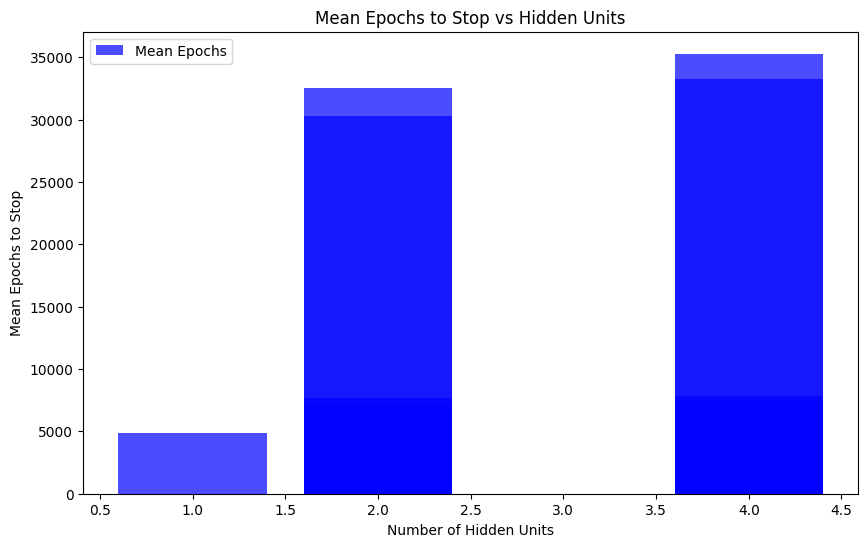

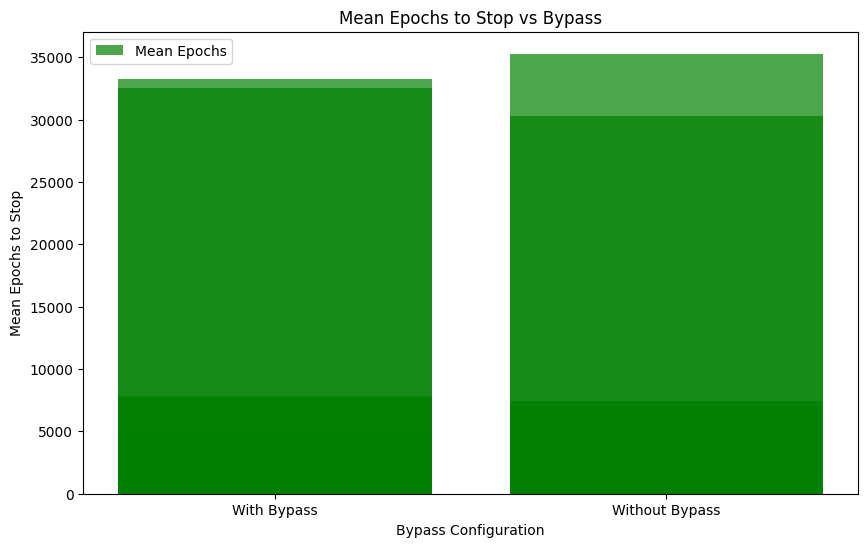

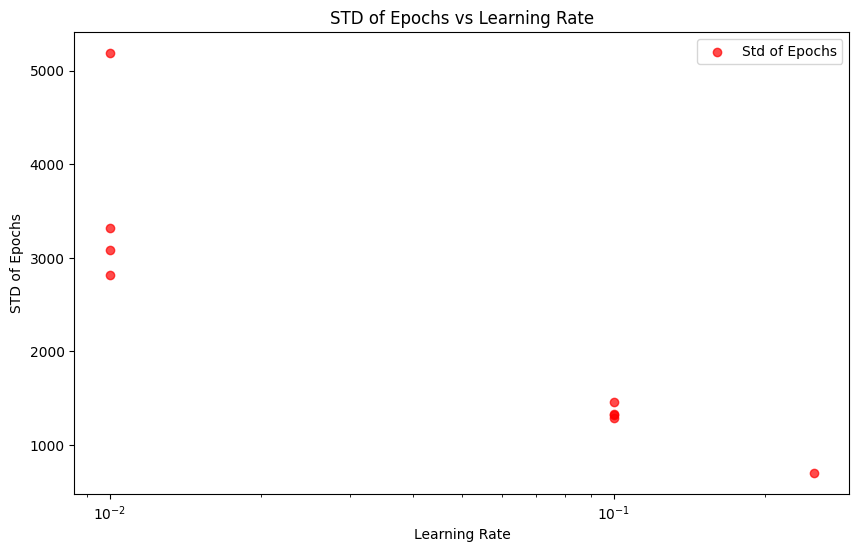

In [10]:
def plot_analysis(exp_results):
    """
    Plot relationships based on the experiment results.

    Parameters
    ----------
    exp_results : list
        The list of experiment results from all trials.
    """
    import matplotlib.pyplot as plt

    hidden_sizes = [exp['hidden'] for exp in exp_results]
    bridges = ["With Bypass" if exp['bypass'] else "Without Bypass" for exp in exp_results]
    learning_rates = [exp['lr'] for exp in exp_results]

    mean_epochs = [exp['mean_epochs'] for exp in exp_results]
    std_epochs = [exp['std_epochs'] for exp in exp_results]

    # Plot 1: Mean Epochs vs. Hidden Units
    plt.figure(figsize=(10, 6))
    plt.bar(hidden_sizes, mean_epochs, color='blue', alpha=0.7, label='Mean Epochs')
    plt.xlabel('Number of Hidden Units')
    plt.ylabel('Mean Epochs to Stop')
    plt.title('Mean Epochs to Stop vs Hidden Units')
    plt.legend()
    plt.show()

    # Plot 2: Mean Epochs vs Bypass
    plt.figure(figsize=(10, 6))
    plt.bar(bridges, mean_epochs, color='green', alpha=0.7, label='Mean Epochs')
    plt.xlabel('Bypass Configuration')
    plt.ylabel('Mean Epochs to Stop')
    plt.title('Mean Epochs to Stop vs Bypass')
    plt.legend()
    plt.show()

    # Plot 3: Std of Epochs vs Learning Rate
    plt.figure(figsize=(10, 6))
    plt.scatter(learning_rates, std_epochs, color='red', alpha=0.7, label='Std of Epochs')
    plt.xlabel('Learning Rate')
    plt.ylabel('STD of Epochs')
    plt.title('STD of Epochs vs Learning Rate')
    plt.legend()
    plt.xscale('log')
    plt.show()


# Execution
# Ensure `results` is the output from `run_all_experiments()`
plot_analysis(results)


# **Figure 1: Mean Epochs vs Hidden Units**

The mean number of epochs increases with the number of hidden units. This implies that networks with more hidden units take longer to converge.
For hidden unit size 1, the network learns faster, possibly because of fewer parameters, but may struggle to model complex functions like XOR accurately.

# **Figure 2: Mean Epochs vs Bypass**

Adding a bypass increases the mean number of epochs. This is expected because the bypass connection introduces more complexity into the network.
Networks without bypass connections may converge faster but might struggle to generalize XOR under challenging conditions.

# **Figure 3: STD of Epochs vs Learning Rate**

A higher learning rate results in lower variability (STD) of epochs. This shows that a higher learning rate accelerates convergence but might miss fine adjustments.
For smaller learning rates (e.g., 0.01), the higher variability suggests inconsistent convergence due to smaller weight updates.

**The results align with theoretical expectations:**

Adding complexity (more hidden units, bypass connections) slows down learning.
Higher learning rates stabilize training but can compromise precision.
Based on these results:

Use a minimal number of hidden units sufficient to model XOR (e.g., 2 or 4).
Consider carefully using bypass connections only when additional complexity is justified.